###  MicroGrad demo

In [1]:
%reload_ext autoreload
%autoreload 2
import random
import numpy as np
import matplotlib.pyplot as plt
from simplegrad import Tensor, Parameter, Sequential, Linear

%matplotlib inline

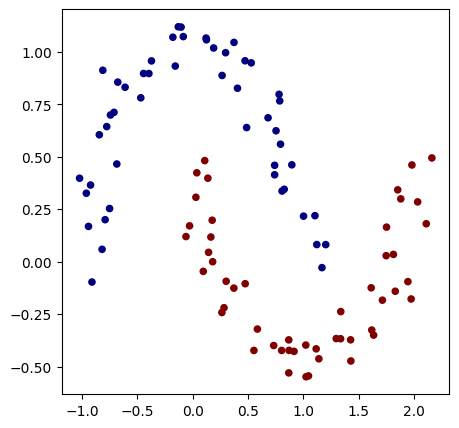

In [2]:
# make up a dataset
np.random.seed(1337)
random.seed(1337)

from sklearn.datasets import make_moons, make_blobs
x_np, y_np = make_moons(n_samples=100, noise=0.1)

y_np = y_np*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(x_np[:,0], x_np[:,1], c=y_np, s=20, cmap='jet')

In [3]:
X = Parameter(Tensor(x_np.reshape(100, 2, 1)), _op='xb')
Y = Parameter(Tensor(y_np.reshape(100, 1, 1)), _op='yb')
print(f'X.shape: {X.shape}, Y.shape: {Y.shape}')
print(X.data.data[:1], Y.data.data[:1])

X.shape: (100, 2, 1), Y.shape: (100, 1, 1)
[[[1.12211461]
  [0.08147717]]] [[[-1]]]


In [4]:
def plot_decision_boundary(model):
    h = 0.25
    X_data = X.data.data
    x_min, x_max = X_data[:, 0].min() - 1, X_data[:, 0].max() + 1
    y_min, y_max = X_data[:, 1].min() - 1, X_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = Parameter(Tensor(np.expand_dims(np.c_[xx.ravel(), yy.ravel()], axis=-1)), _op='xmesh')

    print(Xmesh.shape)
    scores = model(Xmesh)
    Z = (scores.data.data[:, 0, 0] > 0).astype(int)
    Z = (scores.data.reshape(scores.shape[0]) > 0).data.astype(int)
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X_data[:, 0], X_data[:, 1], c=y_np, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

initial accuracy: 24%
Sequential(
   Linear(2 -> 16, activation=relu),
   Linear(16 -> 16, activation=relu),
   Linear(16 -> 1, activation=None)
)
Initial weight sizes: [0.92917, 1.20665, 1.05342, 1.11316, 1.61053, 0.05378]
(315, 2, 1)


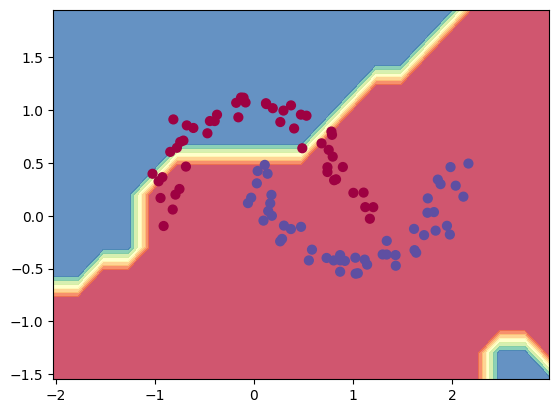

In [5]:
np.random.seed(3)
random.seed(3)
sizes = [2, 16, 16, 1]
model = Sequential([
    Linear(in_size, out_size, activation='relu' if i != len(sizes)-2 else None, no_init=True) 
            for i, (in_size, out_size) in enumerate(zip(sizes[:-1], sizes[1:]))])
preds = model(X)
acc = sum(((Y.data.data > 0) == (preds.data.data > 0))[:, 0, 0])
print(f'initial accuracy: {acc}%')
print(model)
print(f'Initial weight sizes: {[round(x.data.mean().data.item(), 5) for x in [p*p for p in model.parameters()]]}')

plot_decision_boundary(model)

In [6]:
## Model above ## 

def loss(preds):
    # total_loss = preds.mse(Y)
    svm_loss = (1 + -Y*preds).sum()
    return svm_loss

## optimization
base_lr = 0.1

for k in range(100):

    preds = model(X)
    
    # forward
    total_loss = loss(preds)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = base_lr * (1-0.9*k/100)
    for p in model.parameters():
        p.data -= learning_rate * p.grad.sum(dim=0) / 100

    acc = sum(((Y.data.data > 0) == (preds.data.data > 0))[:, 0, 0])
    print(f"step {k} loss {total_loss}, accuracy {acc}%, learning_rate: {learning_rate}")

    # plot_decision_boundary(model)
    if k == 10:
        break


step 0 loss Parameter(data=NumpyTensor(422.16974870137625), grad=1), accuracy 24%, learning_rate: 0.1
step 1 loss Parameter(data=NumpyTensor(66.2628775872859), grad=1), accuracy 55%, learning_rate: 0.09910000000000001
step 2 loss Parameter(data=NumpyTensor(-315.459167321188), grad=1), accuracy 82%, learning_rate: 0.09820000000000001
step 3 loss Parameter(data=NumpyTensor(-710.2116060655211), grad=1), accuracy 83%, learning_rate: 0.0973
step 4 loss Parameter(data=NumpyTensor(-1169.6607514810455), grad=1), accuracy 83%, learning_rate: 0.0964
step 5 loss Parameter(data=NumpyTensor(-1833.2991587117883), grad=1), accuracy 82%, learning_rate: 0.0955
step 6 loss Parameter(data=NumpyTensor(-2858.37299061649), grad=1), accuracy 81%, learning_rate: 0.0946
step 7 loss Parameter(data=NumpyTensor(-4559.421879433134), grad=1), accuracy 82%, learning_rate: 0.0937
step 8 loss Parameter(data=NumpyTensor(-7628.382111365218), grad=1), accuracy 82%, learning_rate: 0.0928
step 9 loss Parameter(data=NumpyTe

(315, 2, 1)


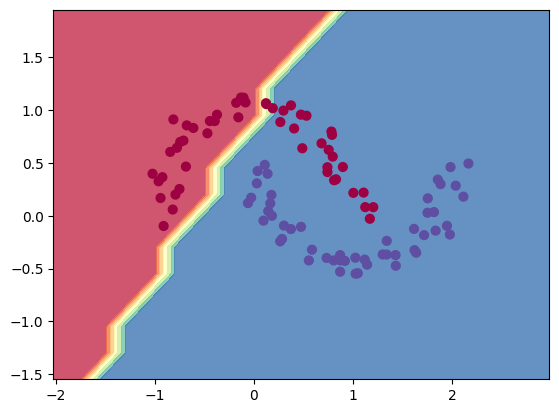

In [7]:
plot_decision_boundary(model)

In [8]:
print(f'Final weight sizes: {[round(x.data.mean().data.item(), 5) for x in [p*p for p in model.parameters()]]}')

Final weight sizes: [3.8895, 3.31616, 1.55135, 1.13698, 9.58068, 0.05378]


initial accuracy: 77%
Sequential(
   Linear(2 -> 16, activation=relu),
   Linear(16 -> 16, activation=relu),
   Linear(16 -> 1, activation=None)
)
Initial weight sizes: [0.87866, 0.50529, 0.96982, 1.2537, 1.21574, 0.00209]
svm_loss: -5.964512265414324, reg_loss: 3.2398870259435704 (323.98870259435705)
step 0 loss Parameter(data=NumpyTensor(-2.724625239470754), grad=1), accuracy 77%, learning_rate: 1.0
svm_loss: -6.02452818176927, reg_loss: 3.115665121618277 (311.5665121618277)
step 1 loss Parameter(data=NumpyTensor(-2.908863060150993), grad=1), accuracy 77%, learning_rate: 0.991
svm_loss: -6.062464380435499, reg_loss: 2.9974585537825638 (299.74585537825635)
step 2 loss Parameter(data=NumpyTensor(-3.0650058266529356), grad=1), accuracy 76%, learning_rate: 0.982
svm_loss: -6.081797173456977, reg_loss: 2.884934480611946 (288.4934480611946)
step 3 loss Parameter(data=NumpyTensor(-3.1968626928450306), grad=1), accuracy 76%, learning_rate: 0.973
svm_loss: -6.084213090422095, reg_loss: 2.7777

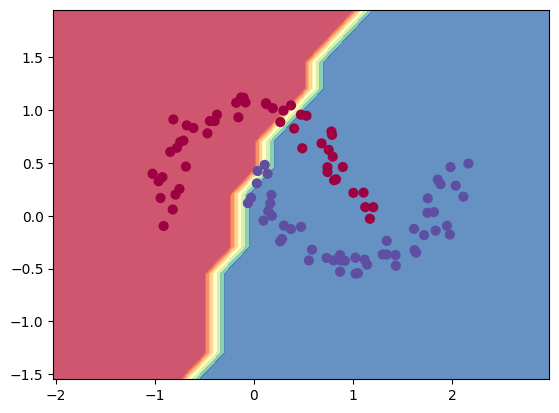

In [22]:
np.random.seed(5)
sizes = [2, 16, 16, 1]
model = Sequential([
    Linear(in_size, out_size, activation='relu' if i != len(sizes)-2 else None, no_init=True) 
            for i, (in_size, out_size) in enumerate(zip(sizes[:-1], sizes[1:]))])
preds = model(X)
acc = sum(((Y.data.data > 0) == (preds.data.data > 0))[:, 0, 0])
print(f'initial accuracy: {acc}%')
print(model)
print(f'Initial weight sizes: {[round(x.data.mean().data.item(), 5) for x in [p*p for p in model.parameters()]]}')

# plot_decision_boundary(model)


## Model above ## 

def loss(preds):
    # total_loss = preds.mse(Y)
    svm_loss = (1 + -Y*preds).sum() / 100
    alpha = 0.01
    param_size = sum([(p*p).sum() for p in model.parameters()]) # L2 regularization
    reg_loss = alpha * param_size

    print(f'svm_loss: {svm_loss.data.mean().data.item()}, reg_loss: {reg_loss.data.mean().data.item()} ({param_size.data.mean().data.item()})')
   
    return svm_loss + reg_loss

## optimization
base_lr = 1

for k in range(100):

    preds = model(X)
    
    # forward
    total_loss = loss(preds)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = base_lr * (1-0.9*k/100)
    for p in model.parameters():
        p.data -= learning_rate * p.grad.sum(dim=0) / 100

    acc = sum(((Y.data.data > 0) == (preds.data.data > 0))[:, 0, 0])
    print(f"step {k} loss {total_loss}, accuracy {acc}%, learning_rate: {learning_rate}")

    # plot_decision_boundary(model)

plot_decision_boundary(model)


In [ ]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    sum([(p*p).sum() for p in model.parameters()])
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)